In [1]:

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import neurokit2 as nk
import scipy.signal as signal
import torch
import torch.nn as nn
import neurokit2 as nk
import tensorflow as tf
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import load_model
from collections import Counter

# Preprocesado de los datos

In [2]:
# carga el documento que debe tener el formato indicado para funcionar
# luego normaliza con valores entre -1 y 1
# filtra las seniales que se consideran ruido

def cargar_y_filtrar(input_file, fs, lowcut=0.5, highcut=40.0, notch_freq=50.0, Q=30.0, order=4):
    df = pd.read_csv(input_file, sep=';', parse_dates=['Timestamp'])
    signal_raw = df['ECG_Value'].values.astype(np.float32)

    b, a = signal.butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    signal_filtered = signal.filtfilt(b, a, signal_raw)

    b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)
    
    signal_filtered = signal.filtfilt(b_notch, a_notch, signal_filtered)
    scaler = MinMaxScaler(feature_range=(0, 1))
    signal_normalizada = scaler.fit_transform(signal_filtered.reshape(-1, 1)).flatten()    
    
    joblib.dump(scaler, "minmaxscaler.pkl")
    
    return df, signal_normalizada

def detectar_r_peaks(signal_filtered, fs):
    signals, info = nk.ecg_process(signal_filtered, sampling_rate=fs)
    r_peaks = info["ECG_R_Peaks"]
    return r_peaks

def guardar_con_picos(df, signal_filtered, r_peaks, output_file):      
    df['Filtered_ECG'] = signal_filtered
    df['R_Peak'] = 0
    df.loc[r_peaks, 'R_Peak'] = 1
    df.to_csv(output_file, sep=';', index=False)
    print(f"Archivo con R Peaks guardado: {output_file}")
    
def segmentar_senal(signal_filtered, segment_length, output_segments_file):
    num_segments = len(signal_filtered) // segment_length
    signal_trimmed = signal_filtered[:num_segments * segment_length]
    signal_segments = signal_trimmed.reshape(num_segments, segment_length)
    np.savetxt(output_segments_file, signal_segments, delimiter=';', fmt='%.6f', header='', comments='')
    print(f"Archivo de segmentos guardado: {output_segments_file}")
    return signal_segments    

In [3]:
input_file = 'ecg_data_5.csv'
output_file = "ecg_data_filtrada_con_picos.csv"
output_segments_file = "ecg_segmentado_187.csv"

# se asigna la frecuencia en hz de las ondas como las de mitbih
fs = 125
# cantidad de segmentos segun la cantidad del dataset
segment_length = 187

# carga y filtrado de los datos para quitar ruido
df, signal_filtered = cargar_y_filtrar(input_file, fs)

# se detectan los r peaks de las seniales
r_peaks = detectar_r_peaks(signal_filtered, fs)

# se genera documento con peaks asignados
# guardar_con_picos(df, signal_filtered, r_peaks, output_file)
# --> los picos 
# se genera documento final con segmentos de 187 filas
signal_segments = segmentar_senal(signal_filtered, segment_length, output_segments_file)


Archivo de segmentos guardado: ecg_segmentado_187.csv


In [4]:
df_processed = pd.read_csv(output_segments_file, sep=';',header=None)
df_processed.head()
#print(df_processed.shape)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.518176,0.523370,0.531837,0.531881,0.515234,0.503050,0.516337,0.535594,0.532358,0.513301,...,0.522705,0.525055,0.524096,0.521848,0.527964,0.527621,0.508403,0.498895,0.511211,0.518360
1,0.515869,0.516029,0.514673,0.513545,0.517652,0.517982,0.514251,0.516944,0.521673,0.519660,...,0.500618,0.529621,0.541869,0.514744,0.527832,0.609032,0.625331,0.539347,0.493512,0.524402
2,0.540643,0.531275,0.533464,0.539117,0.537633,0.536467,0.539008,0.540179,0.536143,0.533751,...,0.501773,0.498294,0.497526,0.495791,0.498507,0.500249,0.491521,0.496758,0.529541,0.547446
3,0.532090,0.521325,0.528551,0.532493,0.527573,0.527107,0.535827,0.535045,0.516296,0.506799,...,0.529836,0.537154,0.537439,0.522070,0.492850,0.495236,0.525328,0.535241,0.529502,0.521148
4,0.504019,0.507364,0.532745,0.522904,0.495997,0.535276,0.598734,0.577554,0.516699,0.506041,...,0.529677,0.590863,0.614059,0.529781,0.468041,0.506208,0.546695,0.546542,0.541198,0.524917


# Modelo de multiperceptrones

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class ECGNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ECGNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

input_size = 187

model = ECGNet(input_size=input_size, num_classes=5)
model.load_state_dict(torch.load("ecg_model_mlp.pth", map_location=device))
model = model.to(device)
# model.eval()


C:\Users\matia\AppData\Local\Temp\ipykernel_9756\2666010489.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_model_mlp.pth", map_lo

In [7]:
df_processed = df_processed.astype(np.float32)

X = torch.tensor(df_processed.values, dtype=torch.float32).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

In [8]:

# Si predictions es un tensor de PyTorch
if isinstance(predictions, torch.Tensor):
    predictions = predictions.cpu().numpy()

# Si predictions tiene más de 1 dimensión, aplanarlo
predictions = np.ravel(predictions)

print("Predicciones realizadas.")
print("Conteo por clase:", np.bincount(predictions))

Predicciones realizadas.
Conteo por clase: [5755]


C:\Users\matia\AppData\Local\Temp\ipykernel_9756\264410370.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_labels, y=counts, palette="pastel")


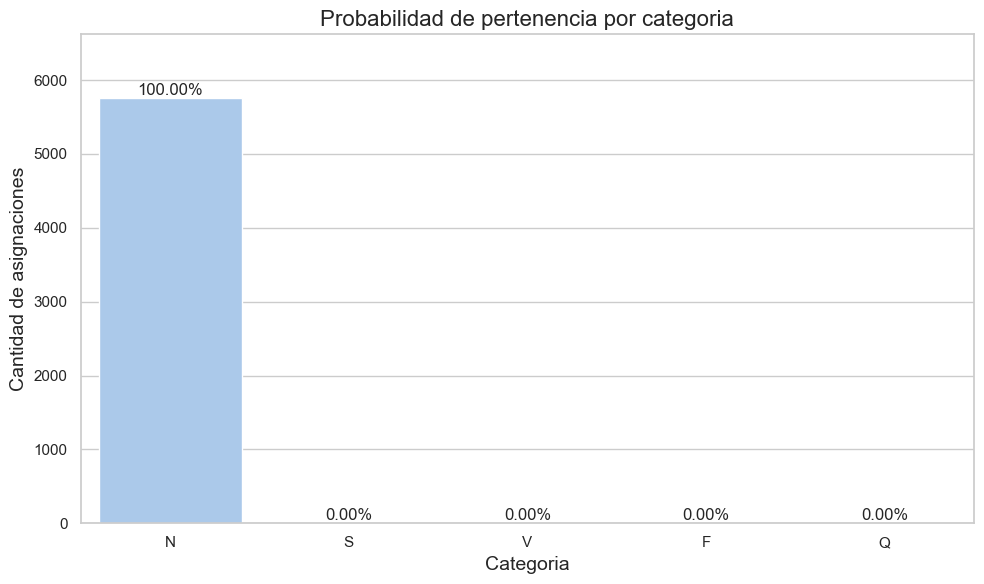

In [9]:
class_labels = ['N', 'S', 'V', 'F', 'Q']

counts = np.bincount(predictions, minlength=5) 
total = counts.sum()
probabilities = counts / total

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=class_labels, y=counts, palette="pastel")

for i, (count, prob) in enumerate(zip(counts, probabilities)):
    plt.text(i, count + 5, f"{prob:.2%}", ha='center', va='bottom', fontsize=12)

plt.title("Probabilidad de pertenencia por categoria", fontsize=16)
plt.xlabel("Categoria", fontsize=14)
plt.ylabel("Cantidad de asignaciones", fontsize=14)
plt.ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# Modelo de redes convolucionales

In [10]:
class ECGCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECGCNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(32 * 46, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGCNN(num_classes=5).to(device)
model.load_state_dict(torch.load("ecg_model_cnn.pth", map_location=device))
# model.eval()

C:\Users\matia\AppData\Local\Temp\ipykernel_9756\645639691.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_model_cnn.pth", map_loc

<All keys matched successfully>

In [11]:
df_processed = df_processed.astype(np.float32)

X = torch.tensor(df_processed.values, dtype=torch.float32).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

In [12]:
print("Predicciones realizadas.")
print("Conteo por clase:", np.bincount(predictions))

Predicciones realizadas.
Conteo por clase: [1104    2   45]


C:\Users\matia\AppData\Local\Temp\ipykernel_9756\3425705938.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_labels, y=counts, palette="pastel")


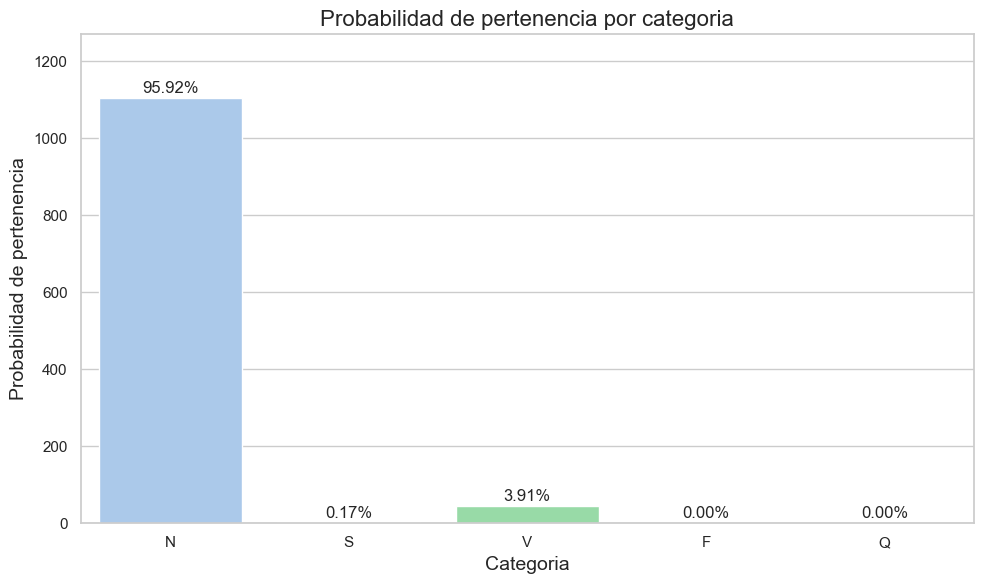

In [13]:
class_labels = ['N', 'S', 'V', 'F', 'Q']

counts = np.bincount(predictions, minlength=5) 
total = counts.sum()
probabilities = counts / total

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=class_labels, y=counts, palette="pastel")

for i, (count, prob) in enumerate(zip(counts, probabilities)):
    plt.text(i, count + 5, f"{prob:.2%}", ha='center', va='bottom', fontsize=12)

plt.title("Probabilidad de pertenencia por categoria", fontsize=16)
plt.xlabel("Categoria", fontsize=14)
plt.ylabel("Probabilidad de pertenencia", fontsize=14)
plt.ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# Modelo Autoencoder

In [14]:
def predecir(modelo, datos, umbral):
    datos_np = datos.values.astype(np.float32)
    reconstrucciones = modelo.predict(datos_np)
    
    # Calcular MAE por muestra (fila)
    mae = np.mean(np.abs(reconstrucciones - datos_np), axis=1)
    
    # Predicción booleana: True si es anómalo (MAE > umbral), False si es normal
    return mae > umbral, mae


In [15]:
autoencoder = load_model('ecg_model_autoencoder.h5')  

df_processed = df_processed.astype(np.float32)

reconstructions = autoencoder.predict(df_processed)

mae = np.mean(np.abs(reconstructions - df_processed), axis=1)

36/36 [==============================] - 0s 501us/step


In [16]:
umbral = np.percentile(mae, 98)  # 0.0867 aprox.

def asignar_categoria(mae, umbral):
    return np.where(mae > umbral, "anómalo", "normal")

categorias = asignar_categoria(mae, umbral)

print(f"Umbral usado: {umbral:.4f}")
print("Conteo de categorías:", Counter(categorias))


Umbral usado: 0.0838
Conteo de categorías: Counter({'normal': 1128, 'anómalo': 23})
